## Import libraries

In [14]:
import os
import sys
import numpy as np
np.set_printoptions(threshold=sys.maxsize)
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='openpyxl')
import pandas as pd
from ydata_profiling import ProfileReport  # One-stop-shop for initial profile of a dataset
import datetime

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import glob

from xgboost import XGBRegressor
from xgboost import plot_importance

from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX

import prophet

## Define reusable functions

#### Function for reading data from model dataset

In [15]:
def read_data(datafile):
    df_data = pd.read_csv(datafile, sep = ',')
    return df_data

#### Function for performing Augmented Dickey-Fuller Stationarity test for time series data

In [16]:
# Check if time series data is stationary
# Null hypothesis of the test is that the series is not stationary.  If p-value < 0.05 then reject null hypothesis.
def dickey_fuller_test(time_series):
    print('Results of Augmented Dickey-Fuller Test:')
    dftest = adfuller(time_series, autolag = 'AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' %key] = value
    print (dfoutput)

# Perform stationarity check using p-value (dftest[1], Test Statistic (dftest[0], and Critical Value for 5% (dftest[4]['5%'])))
    if (dftest[1] < 0.05) and (dftest[0] < dftest[4]['5%']): 
        print('The series is stationary')
    else:
        print('The series is NOT stationary')

#### Function for calculating *Mean Absolute Percentage Error* and *Root Mean Squared Error*

In [17]:
# Calculate Mean Absolute Percentage Error and Root Mean Squared Error
def accuracy(y_test, y_pred):
    mape = np.mean(np.abs(( y_test - y_pred) / y_test)*100)
    rmse = np.sqrt(np.mean((y_test - y_pred)**2 ))
    return(mape, rmse)

#### Function for executing Holt Winter Exponential Smoothing forecast
Forecasts produced using exponential smoothing methods are weighted averages of past observations, with the weights decaying exponentially as the observations get older. In other words, the more recent the observation the higher the associated weight.

In [18]:
def holt_winter(train_data, test_data, seasonal_periods, trend, seasonal):
    hw_model = ExponentialSmoothing(train_data, seasonal_periods = seasonal_periods, trend = trend, seasonal = seasonal)
    hw_fit = hw_model.fit()
    print(hw_fit.summary()) 
    hw_pred = hw_fit.forecast(len(test_data))
    return(hw_pred)

#### Function for executing SARIMA forecast

In [19]:
def sarimax(train_data, test_data, freq):

    # Run auto_arima to determine best order of non-seasonal (p, d, q) and seasonal (P, D, Q) parameters 
    auto_arima_model = auto_arima(train_data, 
                               start_p = 0, start_q = 0,    # minimum p and q, default = 2
                               #max_p = 3, max_q = 3,       # maximum p and q, default = 5
                               m = freq,                    # length of a seasonal period
                               test = 'adf',                # use adftest to find optimal 'd'
                               seasonal = True,             # TRUE if seasonal series
                               d = None, D = None,          # d and D will be set based on result of 'test' and 'seasonal_test'
                               trace = True, 
                               error_action = 'ignore',
                               suppress_warnings = True, 
                               stepwise = True)

    # Collect non-seasonal and seasonal parameters for best arima model
    model_order = auto_arima_model.get_params()['order']
    model_seasonal_order = auto_arima_model.get_params()['seasonal_order']

    # Run SARIMAX with no exogenous variables using non-seasonal and seasonal parameters chosen by auto_arima
    sarima_model = SARIMAX(train_data, order = model_order, seasonal_order = model_seasonal_order) 
    sarima_model_fit = sarima_model.fit()
    print(sarima_model_fit.summary()) 

    # Run predictions on test dataset
    sarima_pred = sarima_model_fit.forecast(len(test_data))
    return(sarima_pred)

#### Function for reviewing results of multiple models

In [20]:
def mod_review(models, demand_name):
    plt.figure(figsize=(12,5))

    for name, y_pred in models.items():
        mape, rmse = accuracy(y_test, y_pred)
        print('================================================================')
        print(name)
        print('Mean Absolute Percentage Error (MAPE) : {:.2f}%'.format(mape))
        print('Root Mean Square Error : {}'.format(rmse))
    
        # Plot forecast
        plt.plot(test.index, y_pred, 'x-', label=name)  # Predictions

    plt.plot(train.index, y_train, 'b.-', label='Train')  # Train data
    plt.plot(test.index, y_test, 'r.-', label='Test')  # Test data
    plt.xlabel('Time', fontsize=10)
    plt.ylabel(demand_name, fontsize=10)
    plt.legend(loc='best')
    plt.title(f'{demand_name} Forecast', fontsize=12)
    plt.show()

#### Set python variables

In [21]:
fpath = "..\\data\\all_raw_files"
fname_model_data = "model_data.csv"

# Set the period of forecast from 2010 to 2020
start_mth = datetime.datetime(2010, 1, 1)
end_mth = datetime.datetime(2020, 12, 1)

#### Read pre-processed multi-variable dataset into pandas dataframe

In [22]:
# Read file
df_model_data = read_data(f'{fpath}\{fname_model_data}')

#### Prepare data for time series modelling

In [23]:
# Convert date column to datetime datatype
df_model_data['date'] = pd.to_datetime(df_model_data['date'])

# Set dataframe index to date column
df_model_data.index = df_model_data.date

# Filter records within start and end month
df_model_data = df_model_data[( df_model_data['date']>=start_mth) & (df_model_data['date'] <= end_mth)]

#### Plot Seasonality and Trend in Timeseries for Average Daily Maximum Demand

In [24]:
pivot_df = df_model_data.pivot_table(index='month', columns='year', values='demand_avg_daily_max')

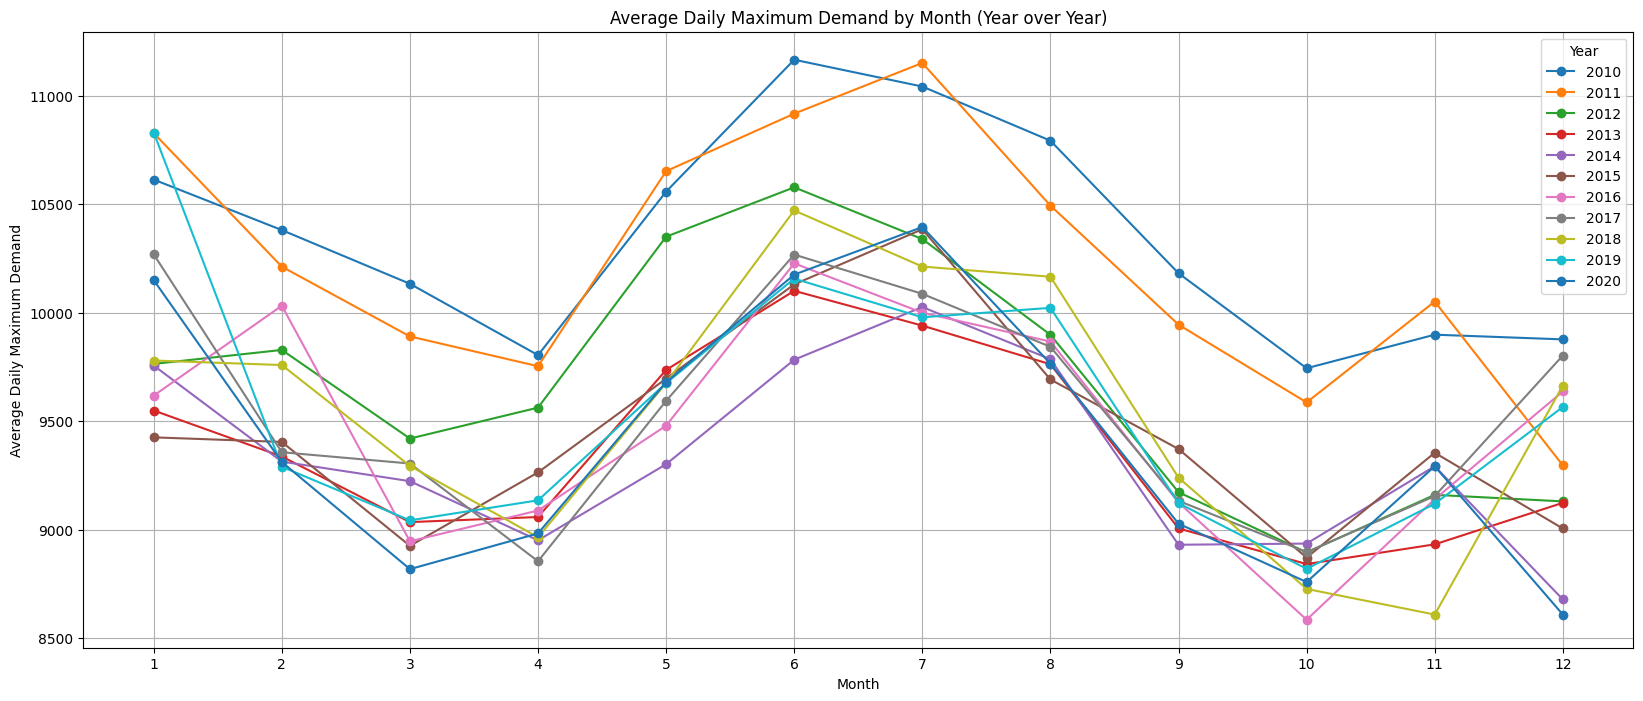

In [25]:
# Plot the line chart
pivot_df.plot(kind='line', marker='o', figsize=(20, 8))
plt.title('Average Daily Maximum Demand by Month (Year over Year)')
plt.xlabel('Month')
plt.ylabel('Average Daily Maximum Demand')
plt.xticks(range(1, 13))  
plt.grid(True)
plt.legend(title='Year', loc='best')
plt.show()

In [26]:
print(df_model_data.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 132 entries, 2010-01-01 to 2020-12-01
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   year                  132 non-null    int64         
 1   month                 132 non-null    int64         
 2   date                  132 non-null    datetime64[ns]
 3   temp_mean             132 non-null    float64       
 4   temp_min              132 non-null    float64       
 5   temp_max              132 non-null    float64       
 6   temp_avg_daily_min    132 non-null    float64       
 7   temp_avg_daily_max    132 non-null    float64       
 8   degree_days           132 non-null    float64       
 9   demand_mean           132 non-null    float64       
 10  demand_max            132 non-null    float64       
 11  demand_avg_daily_max  132 non-null    float64       
 12  total_consumption     132 non-null    float64       
 13  p

#### Perform Augmented Dicky-Fuller Test for Stationarity of Timeseries data for all demand variables

Results of Augmented Dickey-Fuller Test:
Test Statistic                  -2.622951
p-value                          0.088346
#Lags Used                      11.000000
Number of Observations Used    120.000000
Critical Value (1%)             -3.486056
Critical Value (5%)             -2.885943
Critical Value (10%)            -2.579785
dtype: float64
The series is NOT stationary


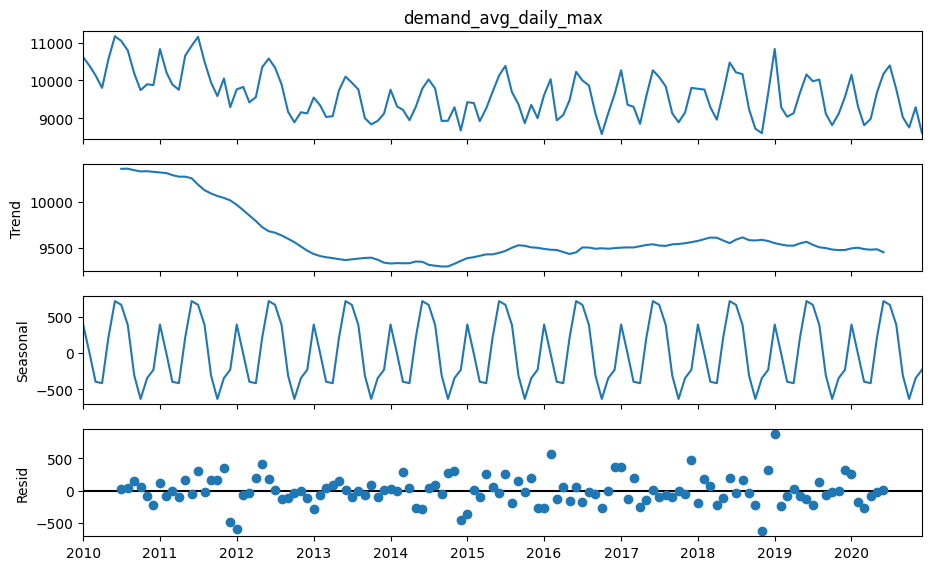

In [27]:
# Apply Augmented Dickey-Fuller test for Average Daily Maximum Demand
dickey_fuller_test(df_model_data.demand_avg_daily_max)

# Check the time series trend, seasonality and residuals (noise component) and analyze.
decomp = seasonal_decompose(df_model_data.demand_avg_daily_max)
fig = decomp.plot()
fig.set_size_inches(10,6)

Results of Augmented Dickey-Fuller Test:
Test Statistic                -6.454477e+00
p-value                        1.495223e-08
#Lags Used                     0.000000e+00
Number of Observations Used    1.310000e+02
Critical Value (1%)           -3.481282e+00
Critical Value (5%)           -2.883868e+00
Critical Value (10%)          -2.578677e+00
dtype: float64
The series is stationary


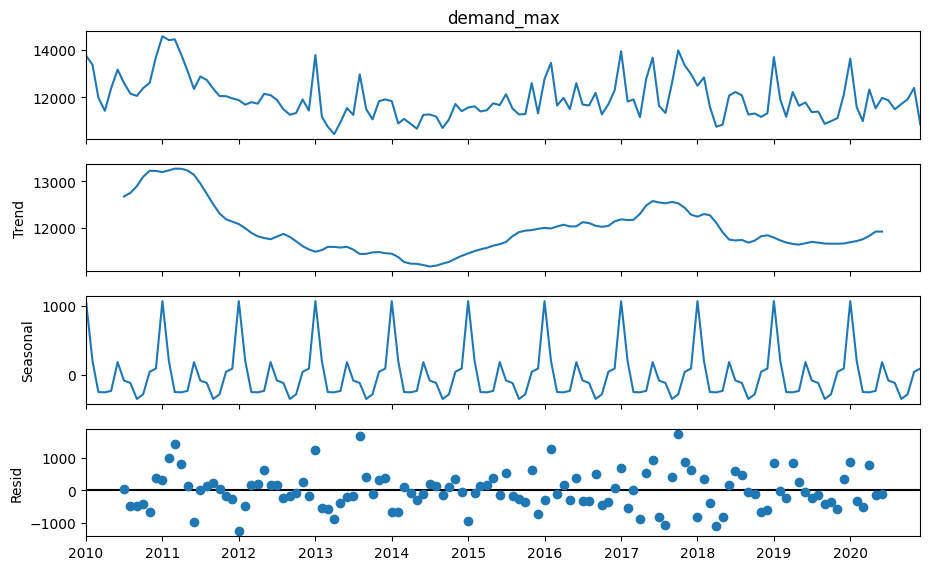

In [28]:
# Apply Augmented Dickey-Fuller test for Maximum (Peak) Demand
dickey_fuller_test(df_model_data.demand_max)

# Check the time series trend, seasonality and residuals (noise component) and analyze.
decomp = seasonal_decompose(df_model_data.demand_max)
fig = decomp.plot()
fig.set_size_inches(10,6)

Results of Augmented Dickey-Fuller Test:
Test Statistic                  -1.821953
p-value                          0.369618
#Lags Used                      13.000000
Number of Observations Used    118.000000
Critical Value (1%)             -3.487022
Critical Value (5%)             -2.886363
Critical Value (10%)            -2.580009
dtype: float64
The series is NOT stationary


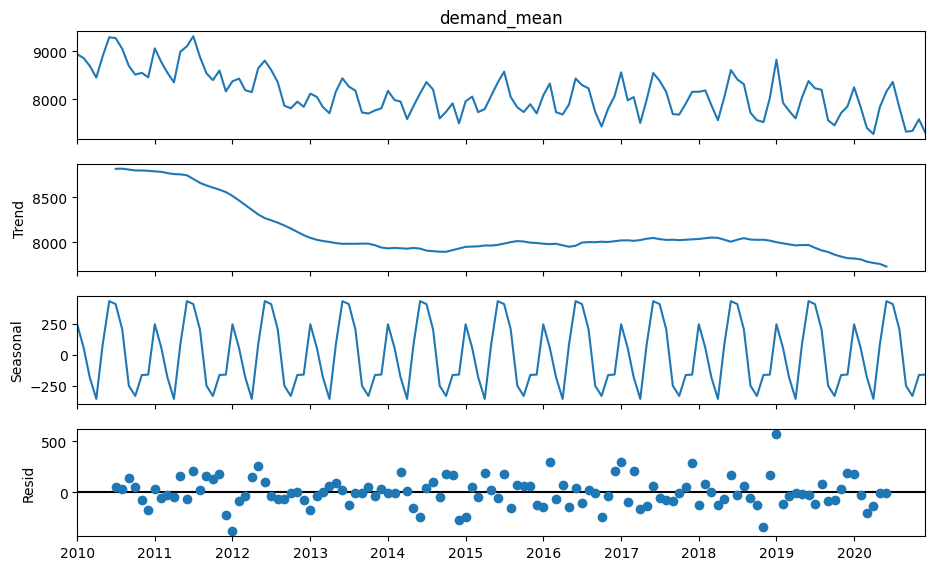

In [29]:
# Apply Augmented Dickey-Fuller test for Mean Demand
dickey_fuller_test(df_model_data.demand_mean)

# Check the time series trend, seasonality and residuals (noise component) and analyze.
decomp = seasonal_decompose(df_model_data.demand_mean)
fig = decomp.plot()
fig.set_size_inches(10,6)

#### Prepare data for time series models

In [30]:
# Set the forecast window to 24 months
forecast_mths = 24 

# Create test and train subsets, where test holds all rows for the last 24 months
train = df_model_data[ : -forecast_mths]
test = df_model_data[-forecast_mths :]

y_train_adm = train['demand_avg_daily_max']
y_test_adm = test['demand_avg_daily_max']

y_train_max = train['demand_max']
y_test_max = test['demand_max']

y_train_mean = train['demand_mean']
y_test_mean = test['demand_mean']

print('Train size: ' + str(train.shape[0]) +   ' , Test size: ' + str(test.shape[0]))


Train size: 108 , Test size: 24


#### Run Holt Winter Exponential Smoothing forecast for *Average Daily Maximum Demand*

In [31]:
# Holt Winter Forecast
y_train = y_train_adm
y_test = y_test_adm

hw_pred = holt_winter(train_data=y_train, test_data=y_test, seasonal_periods=12, trend='mul', seasonal='mul')

C:\Users\JohnD'Souza\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                       ExponentialSmoothing Model Results                       
Dep. Variable:     demand_avg_daily_max   No. Observations:                  108
Model:             ExponentialSmoothing   SSE                        6037835.084
Optimized:                         True   AIC                           1212.594
Trend:                   Multiplicative   BIC                           1255.508
Seasonal:                Multiplicative   AICC                          1220.279
Seasonal Periods:                    12   Date:                 Fri, 19 Apr 2024
Box-Cox:                          False   Time:                         13:30:37
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.2525000                alpha                 True
smoothing_trend          

C:\Users\JohnD'Souza\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\Users\JohnD'Souza\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


#### Run SARIMA forecast for *Average Daily Maximum Demand*

In [32]:
sr_pred = sarimax(train_data=y_train, test_data=y_test, freq=12)

Performing stepwise search to minimize aic


 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=1557.773, Time=1.07 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1633.018, Time=0.84 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1560.892, Time=0.57 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1591.314, Time=0.53 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1631.053, Time=0.04 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=1590.868, Time=0.32 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=1568.692, Time=0.62 sec
 ARIMA(0,1,0)(2,0,1)[12] intercept   : AIC=inf, Time=2.73 sec
 ARIMA(0,1,0)(1,0,2)[12] intercept   : AIC=1557.943, Time=1.75 sec
 ARIMA(0,1,0)(0,0,2)[12] intercept   : AIC=1585.110, Time=0.67 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=1566.185, Time=1.03 sec
 ARIMA(0,1,0)(2,0,2)[12] intercept   : AIC=inf, Time=2.24 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=1546.989, Time=0.89 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=1591.868, Time=0.42 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=1548.101, Time=2.71 sec
 ARIM

C:\Users\JohnD'Souza\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\JohnD'Souza\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:               demand_avg_daily_max   No. Observations:                  108
Model:             SARIMAX(3, 1, 1)x(1, 0, 1, 12)   Log Likelihood                -757.755
Date:                            Fri, 19 Apr 2024   AIC                           1529.509
Time:                                    13:33:36   BIC                           1548.219
Sample:                                01-01-2010   HQIC                          1537.094
                                     - 12-01-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1936      0.180      1.077      0.282      -0.159       0.546
ar.L2         -0.0518      0.108   

#### Review results of SARIMA forecasts for *Average Daily Maximum Demand*

SARIMA
Mean Absolute Percentage Error (MAPE) : 2.48%
Root Mean Square Error : 336.9956802350909


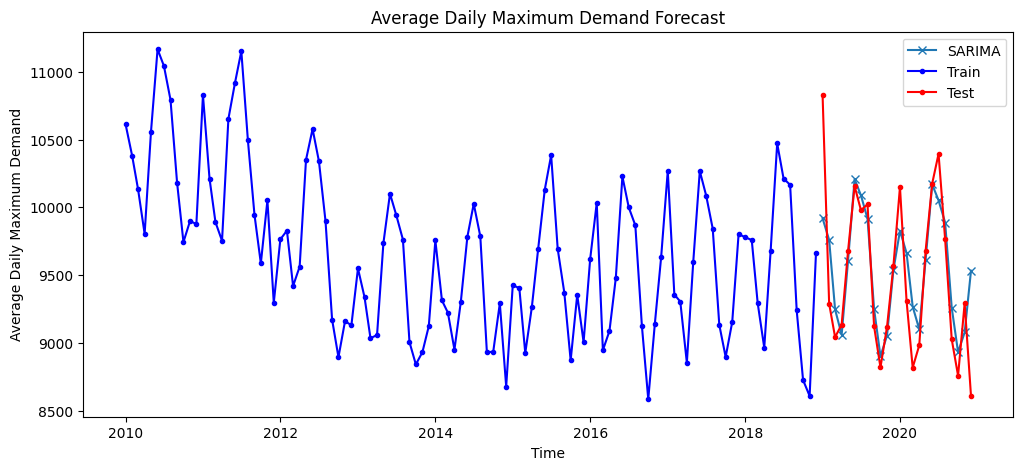

In [33]:
models = {
    #'Holt Winter': hw_pred,
    'SARIMA': sr_pred
}
mod_review(models=models, demand_name='Average Daily Maximum Demand')

#### Review results of Holt Winter forecasts for *Average Daily Maximum Demand*

Holt Winter
Mean Absolute Percentage Error (MAPE) : 1.93%
Root Mean Square Error : 306.2832932592546


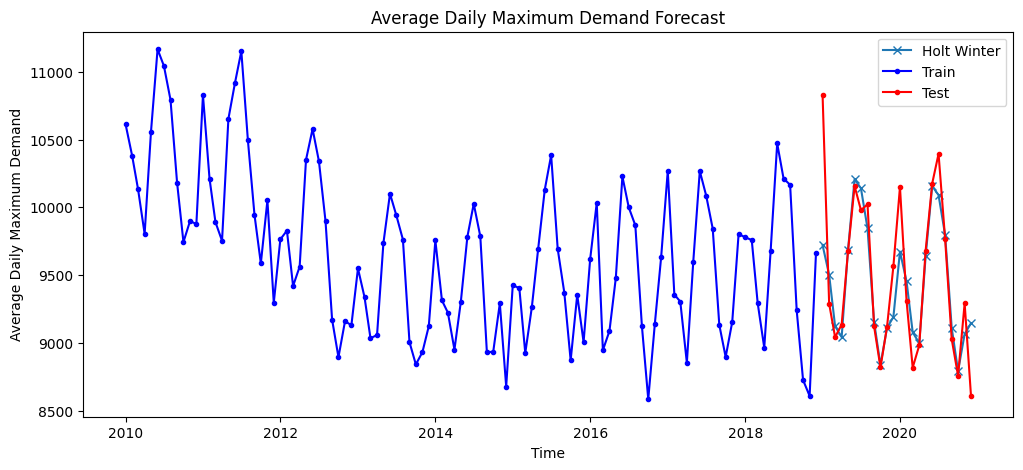

In [34]:
models = {
    'Holt Winter': hw_pred
    #,'SARIMA': sr_pred
}
mod_review(models=models, demand_name='Average Daily Maximum Demand')

#### Run Holt Winter Exponential Smoothing forecast for *Maximum (Peak) Demand*

In [35]:
y_train = y_train_max
y_test = y_test_max

In [36]:
# Holt Winter Forecast

hw_pred = holt_winter(train_data=y_train, test_data=y_test, seasonal_periods=12, trend='mul', seasonal='mul')

C:\Users\JohnD'Souza\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                       ExponentialSmoothing Model Results                       
Dep. Variable:               demand_max   No. Observations:                  108
Model:             ExponentialSmoothing   SSE                       53286352.294
Optimized:                         True   AIC                           1447.778
Trend:                   Multiplicative   BIC                           1490.693
Seasonal:                Multiplicative   AICC                          1455.464
Seasonal Periods:                    12   Date:                 Fri, 19 Apr 2024
Box-Cox:                          False   Time:                         13:33:39
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.4292857                alpha                 True
smoothing_trend          

C:\Users\JohnD'Souza\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


#### Run SARIMA forecast for *Maximum (Peak) Demand*

In [37]:
sr_pred = sarimax(train_data=y_train, test_data=y_test, freq=12)

Performing stepwise search to minimize aic


 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=1.20 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1738.991, Time=0.05 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1737.100, Time=0.38 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1730.943, Time=0.38 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1737.079, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=1729.923, Time=0.13 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=1730.933, Time=0.14 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=inf, Time=1.14 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=1720.646, Time=0.39 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=1722.312, Time=0.60 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=1722.192, Time=0.91 sec
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=inf, Time=1.44 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=1736.354, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[12] intercept   : AIC=1720.320, Time=0.32 sec
 ARIMA(2,1,1)(1,0,0)[12] intercept   : AIC=1721.767, Time=0.76 sec
 ARIMA(2,1

C:\Users\JohnD'Souza\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\JohnD'Souza\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


#### Review results of Holt Winter and SARIMA forecasts for *Maximum (Peak) Demand*

Holt Winter
Mean Absolute Percentage Error (MAPE) : 4.85%
Root Mean Square Error : 749.7109772883357
SARIMA
Mean Absolute Percentage Error (MAPE) : 5.05%
Root Mean Square Error : 861.2647869721638


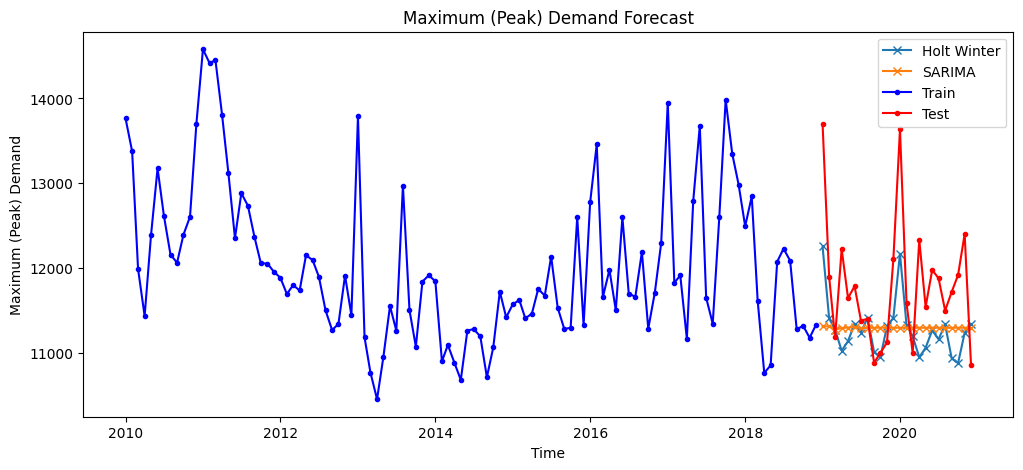

In [38]:
models = {
    'Holt Winter': hw_pred
    ,'SARIMA': sr_pred
}
mod_review(models=models, demand_name='Maximum (Peak) Demand')

#### Run Holt Winter Exponential Smoothing forecast for *Mean Demand*

In [39]:
y_train = y_train_mean
y_test = y_test_mean

In [40]:
# Holt Winter Forecast

hw_pred = holt_winter(train_data=y_train, test_data=y_test, seasonal_periods=12, trend='mul', seasonal='mul')

C:\Users\JohnD'Souza\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                       ExponentialSmoothing Model Results                       
Dep. Variable:              demand_mean   No. Observations:                  108
Model:             ExponentialSmoothing   SSE                        2570200.788
Optimized:                         True   AIC                           1120.355
Trend:                   Multiplicative   BIC                           1163.269
Seasonal:                Multiplicative   AICC                          1128.041
Seasonal Periods:                    12   Date:                 Fri, 19 Apr 2024
Box-Cox:                          False   Time:                         13:34:00
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.2878571                alpha                 True
smoothing_trend          

C:\Users\JohnD'Souza\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


#### Run SARIMA forecast for *Mean Demand*

In [41]:
sr_pred = sarimax(train_data=y_train, test_data=y_test, freq=12)

Performing stepwise search to minimize aic


 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=1461.513, Time=1.28 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1536.355, Time=0.05 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1464.807, Time=0.55 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1490.313, Time=0.53 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1534.436, Time=0.03 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=1497.317, Time=0.35 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=1477.549, Time=0.42 sec
 ARIMA(0,1,0)(2,0,1)[12] intercept   : AIC=1463.091, Time=1.91 sec
 ARIMA(0,1,0)(1,0,2)[12] intercept   : AIC=1462.778, Time=2.15 sec
 ARIMA(0,1,0)(0,0,2)[12] intercept   : AIC=1493.530, Time=0.66 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=1473.347, Time=0.97 sec
 ARIMA(0,1,0)(2,0,2)[12] intercept   : AIC=inf, Time=3.71 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=1447.989, Time=1.21 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=1496.555, Time=0.70 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=1449.668, Time=2.50 sec


C:\Users\JohnD'Souza\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\JohnD'Souza\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                       
Dep. Variable:                          demand_mean   No. Observations:                  108
Model:             SARIMAX(5, 1, 0)x(1, 0, [1], 12)   Log Likelihood                -708.407
Date:                              Fri, 19 Apr 2024   AIC                           1432.815
Time:                                      13:36:21   BIC                           1454.197
Sample:                                  01-01-2010   HQIC                          1441.483
                                       - 12-01-2018                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5695      0.081     -7.016      0.000      -0.729      -0.410
ar.L2         -0.41

#### Review results of Holt Winter and SARIMA forecasts for *Mean Demand*

Holt Winter
Mean Absolute Percentage Error (MAPE) : 1.97%
Root Mean Square Error : 216.08109454560645
SARIMA
Mean Absolute Percentage Error (MAPE) : 2.39%
Root Mean Square Error : 245.12068369473604


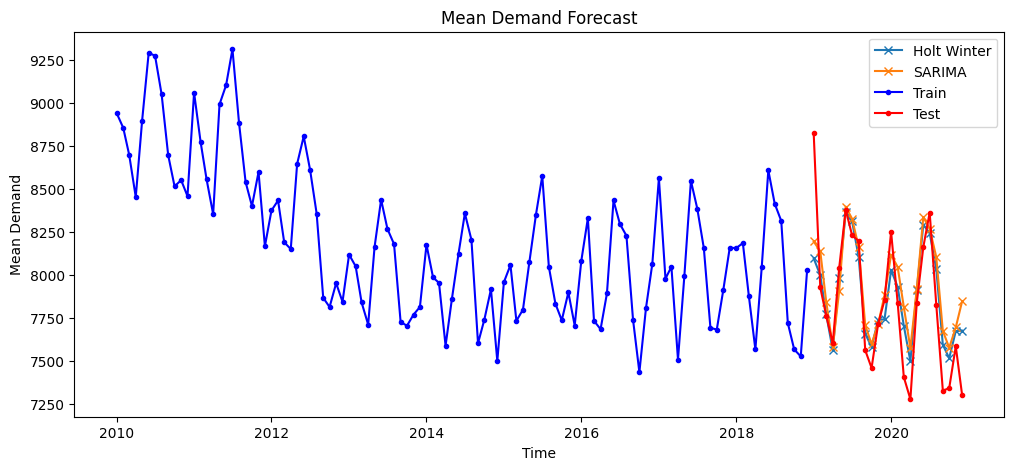

In [42]:
models = {
    'Holt Winter': hw_pred
    ,'SARIMA': sr_pred
}
mod_review(models=models, demand_name='Mean Demand')

In [47]:
type(sr_pred)

pandas.core.series.Series